In [2]:
!pip install -Uqq fastbook kaggle waterfallcharts treeinterpreter dtreeviz
import fastbook
fastbook.setup_book()

In [3]:
import math

In [4]:
!apt install unzip

Reading package lists... Done
Building dependency tree       
Reading state information... Done
Suggested packages:
  zip
The following NEW packages will be installed:
  unzip
0 upgraded, 1 newly installed, 0 to remove and 1 not upgraded.
Need to get 168 kB of archives.
After this operation, 567 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 unzip amd64 6.0-21ubuntu1.1 [168 kB]
Fetched 168 kB in 0s (1222 kB/s)0m
debconf: delaying package configuration, since apt-utils is not installed

78Selecting previously unselected package unzip.
(Reading database ... 15734 files and directories currently installed.)
Preparing to unpack .../unzip_6.0-21ubuntu1.1_amd64.deb ...
7Progress: [  0%] [..........................................................] 87Progress: [ 17%] [#########.................................................] 8Unpacking unzip (6.0-21ubuntu1.1) ...
7Progress: [ 33%] [###################.........................

In [5]:
from fastbook import *

In [6]:
cred_path = Path('~/.kaggle/kaggle.json').expanduser()
cred_path

Path('/root/.kaggle/kaggle.json')

In [7]:
import os

if not cred_path.exists():
    cred_path.parent.mkdir(exist_ok=True)
    os.system("cp -n kaggle.json ~/.kaggle")
    cred_path.chmod(0o600)

In [8]:
#hide
from kaggle import api
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG

pd.options.display.max_rows = 20
pd.options.display.max_columns = 20

In [9]:
from fastai.tabular.all import *

In [10]:
data_path = Path('/storage/data/titanic')
data_path.exists()

True

In [11]:
if not data_path.exists():
    os.system("mkdir /storage/data/titanic")

In [12]:
csv_names = ('train.csv', 'test.csv', 'gender_submission.csv')
for csv in csv_names:
    path = data_path/csv
    if not path.exists():
        os.system('kaggle competitions download -c titanic')
        os.system('mv titanic.zip /storage/data/titanic')
        os.system('unzip /storage/data/titanic/titanic.zip')
        os.system('rm /storage/data/titanic/titanic.zip')
        
for csv in csv_names:
    assert (data_path/csv).exists()

### Helper functions for training, fitting and error calculation

In [13]:
def r_mse(pred, y): return round(math.sqrt(((pred-y)**2).mean()), 6)

In [14]:
def error(pred, y):
    return torch.where(pred != y)[0].size()[0] / pred.size()[0]

In [15]:
def categorize_df(df : pd.DataFrame):
    df['Pclass'] = df['Pclass'].astype(pd.CategoricalDtype(categories=[1,2,3], ordered=True))
    return df

In [16]:
def augment_data(df : pd.DataFrame):
    df['Cabin_na'] = df['Cabin'].isnull()
#     df = df.drop(columns='Cabin')
    df['Fare'] = df['Fare'].replace(to_replace=0, value=df['Fare'].median())
    return df

In [17]:
def preprocess(df : pd.DataFrame):
    df = categorize_df(df)
    df = augment_data(df)
    return df

In [18]:
def create_dl(df, dep_var='Survived', splits=None, procs=(Categorify, FillMissing)):
    with no_random():
        # Split the dataframe into the continuous and categorical labels as the dataloader needs it
        cont_names,cat_names = cont_cat_split(df, dep_var=dep_var)

        dl = TabularPandas(
            df,
            procs,
            cat_names=cat_names,
            cont_names=cont_names,
            y_names=dep_var,
            splits=splits,
            reduce_memory=False)
    return dl

In [19]:
def fit_and_calc_error(dl, rf):
    '''
    1. Call fit on the model
    2. Make predictions for training & validation data
    3. Calc error from predictions in training & validation data
    '''
    with no_random():
        rf.fit(dl.train.xs, dl.train.y)
        
    predicted_train_ys = tensor(rf.predict(dl.train.xs))
    train_error = error(predicted_train_ys, tensor(dl.train.ys).squeeze() )
    # train_rmse = r_mse(predicted_train_ys, dl.train.ys)
    predicted_valid_ys = tensor(rf.predict(dl.valid.xs))
    valid_error = error(predicted_valid_ys, tensor(dl.valid.ys).squeeze() )
    # valid_rmse = r_mse(predicted_valid_ys, dl.valid.ys)
    return (rf, train_error, valid_error)

In [20]:
def feat_imp(model, x_names):
    return pd.DataFrame({'names' : x_names, 'imp' : model.feature_importances_ }).sort_values('imp', ascending=False)

In [21]:
def fit_calc_error_and_plot(dl, rf):
    rf, train_error,valid_error = fit_and_calc_error(dl, rf)
    feat_imp(rf, dl.train.xs.columns).plot(x='names',kind='barh')
    return rf,train_error,valid_error

In [22]:
test_df = pd.read_csv(data_path/'train.csv', low_memory=False)
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [23]:
test_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


### Data checks (TODO Evaluate whether to do this or not. skipping for now)

#### Null values

Age and Cabin have the main null values. Embarked has a couple of nulls.
Check suitable fill values for nulls? There are columns to specify if age, cabin and embarked have null values. Ex. `Age_na`. Then when we check feature importance, it will tell us how important it is that the column is null.

### Pipeline for building dataloader, model, fitting and error calculation

/opt/conda/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


train_error = 0.2426367461430575
valid_error=0.21910112359550563
score=0.7808988764044944
oob_score=0.7419354838709677


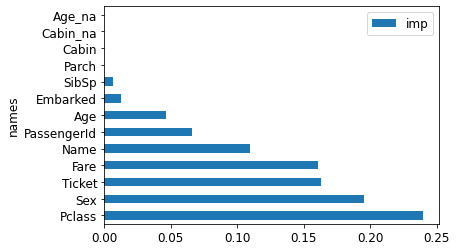

In [24]:
def pipeline(df, min_samples_leaf=30, max_samples=100, max_features=3):
    with no_random():
#         df = df.drop(columns='Fare')
        # The passenger class is really an ordered categorical variable with
        # 1st class being the "highest" and 3rd being the lowest
#         df = augment_data(df)
        df = preprocess(df)
        # split randomly into training & validation
        train,valid = RandomSplitter(seed=42)(df)
        # Create scikit classifier - random forest
        rf = RandomForestClassifier(
                n_jobs=-1,
                min_samples_leaf=min_samples_leaf,
                max_samples=max_samples,
                max_features=max_features,
                oob_score=True,
                random_state=42)

        dl = create_dl(df, splits=(train,valid))
        rf, train_error, valid_error = fit_calc_error_and_plot(dl, rf)
        score = rf.score(dl.valid.xs, dl.valid.ys)
        print(f'train_error = {train_error}\nvalid_error={valid_error}\nscore={score}\noob_score={rf.oob_score_}')
        return rf,dl

df = pd.read_csv(data_path/'train.csv', low_memory=False)
default_rf,default_dl = pipeline(df)


# (0.24544179523141654, 0.21910112359550563)

In [25]:
random_grid = {
    'n_estimators' : [10, 100, 1000],
    'min_samples_leaf' : [5, 10, 30, 60],
    'max_features' : [1, 3, 5, 'sqrt', 'log2'],
    'max_samples' : [100, 300, 500, 700],
    'max_depth' : [None, 10, 50, 100]
}

In [26]:
# rf_random = RandomizedSearchCV(default_rf, random_grid, n_iter=25, n_jobs=-1, random_state=42)
# rf_random = GridSearchCV(default_rf, random_grid, n_jobs=-1)
rf_random = HalvingGridSearchCV(default_rf, random_grid, n_jobs=-1, random_state=42)

In [27]:
rf_random = rf_random.fit(default_dl.train.xs, default_dl.train.ys)

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Pl

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 

  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConvers

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 

  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConvers

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 

  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConvers

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 

  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConvers

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 

  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConvers

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 

  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConvers

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
1600 fits failed out of a total of 1600.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
228 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/_forest.py", line 380, in fit
    n_samples=X.shape[0], max_samples=self.max_samples
  File "/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/_forest.py", line 111, in _get_n_samples_bootstrap
    raise ValueError(msg.format(n_samples, max_sa

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 

/opt/conda/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 

/opt/conda/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 

/opt/conda/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 

/opt/conda/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 

/opt/conda/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for e

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
410 fits failed out of a total of 535.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
69 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/_forest.py", line 380, in fit
    n_samples=X.shape[0], max_samples=self.max_samples
  File "/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/_forest.py", line 111, in _get_n_samples_bootstrap
    raise ValueError(msg.format(n_samples, max_sampl

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
140 fits failed out of a total of 180.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
54 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/_forest.py", line 380, in fit
    n_samples=X.shape[0], max_samples=self.max_samples
  File "/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/_forest.py", line 111, in _get_n_samples_bootstrap
    raise ValueError(msg.format(n_samples, max_sampl

In [28]:
# Best params with Randomized
# {'n_estimators': 100,
#  'min_samples_leaf': 10,
#  'max_samples': 300,
#  'max_features': 'sqrt',
#  'max_depth': 50}

# Best params with HalvingGridSearchCV and resource = n_estimators
# {'max_depth': 10,
#  'max_features': 3,
#  'max_samples': 700,
#  'min_samples_leaf': 60,
#  'n_estimators': 810}

rf_random.best_params_

{'max_depth': None,
 'max_features': 3,
 'max_samples': 700,
 'min_samples_leaf': 30,
 'n_estimators': 1000}

In [29]:
best_est = rf_random.best_estimator_

In [30]:
# Best with Randomized - (0.8541374474053296, 0.8258426966292135, 0.814866760168303)
# HalvingGridSearchCV with n_estimators as resource (0.7896213183730715, 0.8089887640449438, 0.7812061711079944)

valid_score = best_est.score(default_dl.valid.xs, default_dl.valid.ys)
train_score = best_est.score(default_dl.train.xs, default_dl.train.ys)
train_score,valid_score,best_est.oob_score_

(0.8260869565217391, 0.8202247191011236, 0.7994389901823282)

<AxesSubplot:ylabel='names'>

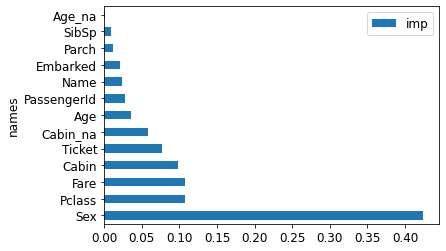

In [32]:
feat_imp(best_est, default_dl.train.xs.columns).plot(x='names',kind='barh')

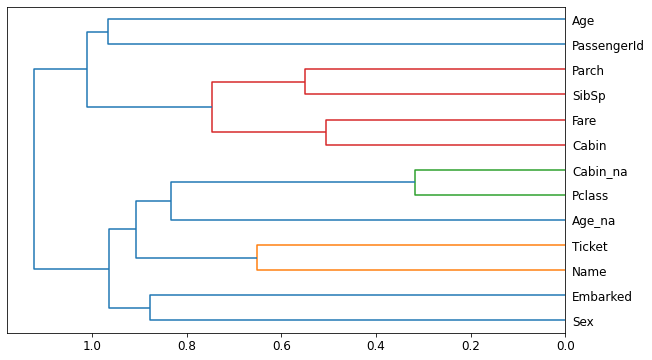

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 

In [33]:
cluster_columns(default_dl.xs)

## Data exporation. Trying to understand the data

Need to see how what percentage of each fare "category" survived. split fare into categories of '30'

In [23]:
fare_df = df.set_index('Fare')

In [30]:
max_fare = math.ceil(df['Fare'].max())
for i in range(0, max_fare + 30, 30):
    range_label = f'{i} - {i + 30}'
    range_df = df[ (df['Fare'] > i) & (df['Fare'] <= i + 30) ]
    num_in_range = len(range_df)

In [37]:
# calc the num first / num second / num third
# plot percentages of each (Survived, Died) on a bar plot
# doing 2 bars for each pclass (survived %, died %)
# survived % = num

# def calc_percent_survived_in_cat_value(cat_name):

cats = []
percent_survived = []

for cat in df['Pclass'].cat.categories:
    num_in_cat = len(df[ df['Pclass'] == cat])
    num_cat_survived = len(df[ (df['Pclass'] == cat) & (df['Survived'] == 1)])
    cats.append(cat)
    percent_survived.append(num_cat_survived * 100 / num_in_cat)

class_df = pd.DataFrame({'classes' : cats, 'survived_percent' : percent_survived})
class_df

,classes,survived_percent
0,1,62.962963
1,2,47.282609
2,3,24.236253


In [38]:
cont,cat

(['PassengerId', 'Age', 'Fare'], 3)

<AxesSubplot:>

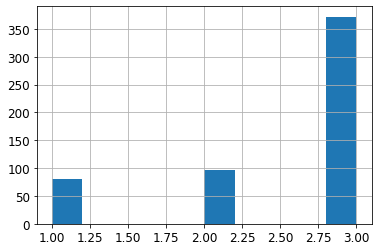

In [75]:
df[df['Survived'] == 0]['Pclass'].hist()

### Making Submission

In [53]:
test_df = pd.read_csv(data_path/'test.csv', low_memory=False)
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [54]:
test_df['Fare'] = test_df['Fare'].fillna(value=test_df['Fare'].median())
test_df = preprocess(test_df)
test_dl = create_dl(test_df, dep_var=None)

In [65]:
print(test_dl.x_names)
# ['Pclass', 'Name', 'Sex', 'SibSp', 'Parch', 'Ticket', 'Cabin', 'Embarked', 'Age_na', 'PassengerId', 'Age', 'Fare', 'Survived']

['Pclass', 'Name', 'Sex', 'SibSp', 'Parch', 'Ticket', 'Cabin', 'Embarked', 'Cabin_na', 'Age_na', 'Fare_na', 'PassengerId', 'Age', 'Fare']


In [55]:
best_est.predict(test_dl.xs)

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
     

In [77]:
submit_df = pd.DataFrame()
submit_df['PassengerId'] = test_df['PassengerId']
submit_df['Survived'] = best_est.predict(test_dl.xs)
submit_df.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


In [78]:
submit_df.to_csv('submission.csv', index=False)